In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
using DiffEqFlux
using Optim
using ForwardDiff
using DelimitedFiles
using LineSearches

In [2]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [3]:
# function limit_func(param,pmin,pmax)
#     if pmin <= param <= pmax
#         return param
#     elseif param < pmin
#         return pmin
#         # param = pmin
#     else
#         return pmax
#         # param = pmax
#     end
#     # return param
# end

function limit_func(param,pmin,pmax)
    (pmax - pmin) * (1/(1 + exp(-param))) + pmin
end

function inv_limit_func(param,pmin,pmax)
    # -log( (pmax - pmin  + 2e-8) / (param - pmin + 1e-8) - 1)
    -log( (pmax - pmin) / (param - pmin) - 1)
end

function alpha(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = limit_func(p[4],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

dalphadt(p, t) = ForwardDiff.derivative(t̃ -> alpha(p,t̃), t)
dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)
ddalphadpdt(p, t) = ForwardDiff.gradient(p̃ -> dalphadt(p̃,t), p)

function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ <= t <= Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

function pulse(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    Tᵣ = limit_func(p[1],0,Tₚ/2)
    # αmin = p[4]
    ϕ = p[5]
    f = p[6]
    A = p[7]
    # Φ_ext = p[8]
    λ = p[9]

    amp = pi * A / (Tₚ - Tᵣ)
    E = amp
    Edot = copy(amp)
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) + Edot*λ*sin(arg)
end

dpulsedt(p, t) = ForwardDiff.derivative(t̃ -> pulse(p, t̃), t)
dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

In [4]:
#[Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
# p = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]
# p = [3.65, #14.84292607534555
# 11.341751839758764,
# 10.0,
# 0.501, #-649.7661732132904
#  0.5828557110984577,
# -7.161153490188593,
#  1.3640811715268795,
# -22.06506034791423,
# -4.957612200539009]
p = [2, 10, 10, 0.51, 0.0, 1.5*2.482542369189332, 1.5/0.2949509890806259, 0.995pi, 0.0]


p[1] = inv_limit_func(p[1],0,15 - p[2])
p[2] = inv_limit_func(p[2],0,15)
p[4] = inv_limit_func(p[4],0.5,1)

-3.8918202981106256

In [5]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3));

M = Pot3Const * exp(im * phi_ext) * Pot3Mat

# fu0 = ψs[:,1:2]

# N=30
# # Ua = ψs[:,1:N]'*Potential3*ψs[:,1:N]
# Um = ψs[:,1:N]'*(Pot3Const * exp(im * phi_ext) * Pot3Mat) * ψs[:,1:N]
# Uv = ψs[:,1:N]'*chargecoupling*ψs[:,1:N]
ψ0 = ψs[:,1:2]#zeros(N,2)
# ψ0[1,1] = 1.0
# ψ0[2,2] = 1.0

u0 = ψs[:,1:2]#cat(real(Es[1:N].-Es[1]),Um,Uv,ψ0,dims=2)

Hphimærke = dPot3_dphi(phi_ext)
Hphi = KinPot12 + Potential3
IdNH = diagm(ones(ComplexF64, NHilbert))
E1mærke = ψs[:,1]'* Hphimærke * ψs[:,1]
E2mærke = ψs[:,2]'* Hphimærke * ψs[:,2]
tmp1 = - (Hphi - (real(Es[1]) .* IdNH)) \ (Hphimærke - (E1mærke .* IdNH))
tmp2 = - (Hphi - (real(Es[2]) .* IdNH)) \ (Hphimærke - (E2mærke .* IdNH))

fu0 = cat(u0,-tmp1*ψs[:,1],-tmp2*ψs[:,2],dims=2)

sizep = length(p)

9

In [8]:
# function f!(du, u, p, t)
#     x = u[:,1:2]
#     ψ = u[:,3:4]
#     H = KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling

#     du[:,1:2] = -im .* (H * x)
#     du[:,3:4] = -im .* (H * ψ) - alpha(p,t) .* ((M - M') * x)
# end

# Uv = chargecoupling
# Ua = Potential3#Um + Um'
# dUa = M - M'

# function b!(du, u, p, t)
#     x = u[:,1:2]
#     ψ = u[:,3:4]
#     λ = u[:,5:6]
#     ϕ = u[:,7:8]
#     ps = u[:,9]

#     miH = -im .* (KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling)

#     du[:,1:2] = miH * x
#     du[:,3:4] = miH * ψ - alpha(p,t) * dUa * x
#     du[:,5:6] = miH * λ
#     du[:,7:8] = miH * ϕ + alpha(p,t) * dUa * λ
    
#     du[1:sizep,9] = (
#     - real(im * tr(λ' * Uv * x)) .* dpulsedp(p, t) 
#     - real(im * tr(λ' * Ua * x)) .* dalphadp(p,t) )
    
#     du[8,9] = real(tr(λ' * dUa * x) * alpha(p,t))
    
#     du[sizep+1:2*sizep,9] = (
#     - real(im * (tr(ϕ' * Uv * x) + tr(ψ' * Uv * λ))) .* dpulsedp(p,t) 
#     - real(im * (tr(ϕ' * Ua * x) + tr(ψ' * Ua * λ))) .* dalphadp(p,t) 
#     # + real(tr(ϕ' * (F .* Ua) * x) + tr(ψ' * (F .* Ua) * λ)) .* ddalphadpdt(p,t) 
#     - real(tr(x' * dUa * λ)) .* dalphadp(p,t) )
#     # - real(im * tr(x' * (F .* dUa)' * λ)) .* ddalphadpdt(p,t)
# end
# phi_ext = 0.9955pi
# Potential3 = get_Pot3(phi_ext)
function f!(du, u, p, t)
    x = u[:,1:2]
    H = KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling

    du[:,1:2] = -im .* (H * x)
end

M = Pot3Const * exp(im * phi_ext) * Pot3Mat
Uv = chargecoupling
Ua = Potential3#Um + Um'
dUa = M - M'

function b!(du, u, p, t)
    x = u[:,1:2]
    λ = u[:,3:4]
    ps = u[:,5]

    miH = -im .* (KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling)

    du[:,1:2] = miH * x
    du[:,3:4] = miH * λ
    
    du[1:9,5] = (
    - real(im * tr(λ' * Uv * x)) .* dpulsedp(p, t) 
    - real(im * tr(λ' * Ua * x)) .* dalphadp(p,t) )
    
    du[8,5] = real(tr(λ' * dUa * x) * alpha(p,t))
end

b! (generic function with 1 method)

In [25]:
m = 0.001/pi
l1s = []
l2s = []
params = []
calls = [1]

grad = zeros(sizep)
loss = [0.0]

function calc(p, last_p, grad, loss)
    if p != last_p
        copy!(last_p, p)
        forward_prob = ODEProblem(f!, ψs[:,1:2], (0.0, 30.0), p)
        sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        # DT = sol_f.u[end][:,1]
        # UmT = sol_f.u[end][:,2:N+1] #Ua = Um + Um'
        # UvT = sol_f.u[end][:,N+2:2*N+1]
        xT = sol_f.u[end][:,1:2]
        # ψT = sol_f.u[end][:,3:4]

        λ = cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)
        # ϕ = cat(-ψ0[:,2]*ψ0[:,2]'*ψT[:,1],-ψ0[:,1]*ψ0[:,1]'*ψT[:,2],dims=2)

        ps = zeros(289,1) #only 2*length(p) are possibly used
        bu0 = cat(xT,λ,ps,dims=2)#cat(xT,ψT,λ,ϕ,ps,dims=2);

        backward_prob = ODEProblem(b!, bu0, (30.0, 0.0), p)
        sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        UT = abs2.(ψ0'*xT)
        infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])
        grad_phi = real(sol_b.u[end][8,5])

        loss[1] = infidelity + m * abs(grad_phi)
        grad[:] = real(sol_b.u[end][1:sizep,5]) #+ m * sign(grad_phi) .* real(sol_b.u[end][sizep+1:2*sizep,9])

        push!(l1s, copy(infidelity))
        push!(l2s, copy(grad_phi))
        push!(params, copy(p))

        if sum(calls)%20 == 0
            writedlm("tmp_l1s8.txt",l1s)
            writedlm("tmp_l2s8.txt",l2s)
            writedlm("tmp_params8.txt",params)
            writedlm("tmp_calls8.txt",calls)
        end
    end
end


function opt_func(p, last_p, grad, loss)
    calc(p, last_p, grad, loss)
    push!(calls, 0)
    return loss[1]
end

function get_grad!(grad, p, last_p, loss)
    calc(p, last_p, grad, loss)
    push!(calls,1)
    println(l1s[end]," ",l2s[end]," ",loss[1],"\n",params[end])
end


get_grad! (generic function with 1 method)

In [26]:
initial_p = copy(p)
last_p = similar(initial_p);

In [27]:
res = optimize(p -> opt_func(p, last_p, grad, loss),
               (grad, p) -> get_grad!(grad, p, last_p, loss),
               initial_p,BFGS(linesearch=LineSearches.MoreThuente()),Optim.Options(g_tol=1e-4,f_tol=1e-6))

In [12]:
res

 * Status: success

 * Candidate solution
    Final objective value:     7.907530e-02

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 6.75e-14 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.96e-15 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.08e-15 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.63e-14 ≤ 1.0e-06
    |g(x)|                 = 5.58e+00 ≰ 1.0e-04

 * Work counters
    Seconds run:   5569  (vs limit Inf)
    Iterations:    23
    f(x) calls:    262
    ∇f(x) calls:   262


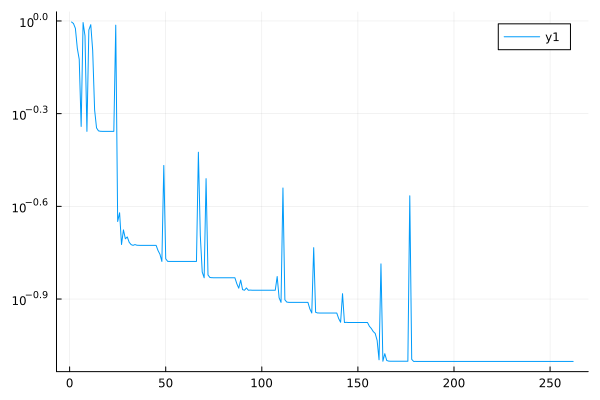

In [13]:
# plot([l1s,l2s])
plot(l1s + m*abs.(l2s),yaxis=:log)

In [15]:
p_new[8]/pi

7.912654680045747

In [14]:
p_new = copy(Optim.minimizer(res))

9-element Vector{Float64}:
 -1.0177146653225322
 -4.216700492593594
 10.0
 -4.346381082859986
  0.07524012770125946
  2.615700838103222
  5.607655464198725
 22.78579795028264
  0.8793831303271845

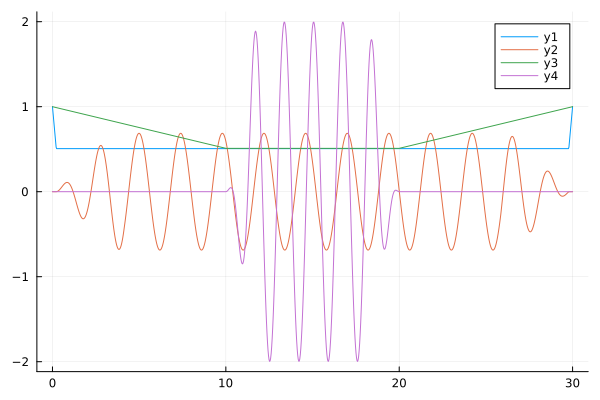

In [15]:
times = LinRange(0,30,1000)
plot(times, [[alpha(p_new,t) for t in times],
             [pulse(p_new,t) for t in times],
             [alpha(p,t) for t in times],
             [pulse(p,t) for t in times]])

In [16]:
# params[end] #[Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
l1s[end], l2s[end]

(0.07730044348246912, -5.575868061697991)

In [17]:
writedlm("tmp_l1s7.txt",l1s)
writedlm("tmp_l2s7.txt",l2s)
writedlm("tmp_params7.txt",params)
writedlm("tmp_calls7.txt",calls)

In [18]:
function fidel(phi_ext,ps)
    Potential3 = get_Pot3(phi_ext)
    Es, ψs = eigs(KinPot12 + Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000);

    function H!(du, u, p, t)
        du[:] = - im * (KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling) * u
    end

    forward_prob = ODEProblem(H!, ψs, (0.0, 30.0), ps)
    sol = solve(forward_prob, p=ps, save_everystep=false, reltol=1e-8, abstol=1e-10)

    UT = abs2.(ψs'*sol.u[end])
    return 0.5 * (2 - UT[1,2] - UT[2,1])
end    

fidel (generic function with 1 method)

In [19]:
phis = cat([0.993,0.99325,0.9935,0.99375,0.994],LinRange(0.994,0.99475,7)[2:end-1],LinRange(0.99475,0.995,7),dims=1)
phis = cat(phis, reverse(0.995 .+ (0.995 .- phis))[2:end],dims=1)
;

In [20]:
tmp_losses = []
for phi in phis
    push!(tmp_losses,fidel(phi*pi,p_new))
end

┌ Warning: Skipped marker arg o.
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1203
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :log10]
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1641


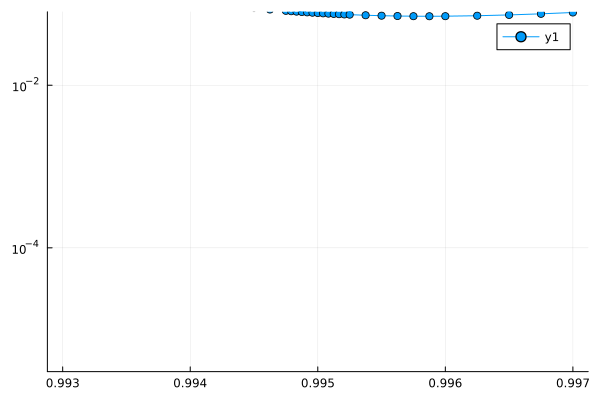

In [24]:
plot(phis,tmp_losses,yscale=:log,marker="o",ylim=(3e-6,8e-2))

In [80]:
using ProgressMeter

In [84]:
phis = cat([0.993,0.99325,0.9935,0.99375,0.994],LinRange(0.994,0.99475,7)[2:end-1],LinRange(0.99475,0.995,7),dims=1)
# phis = [0.993,
# 0.9935,
# 0.994,
# 0.99475,
# 0.9948,
# 0.99485,
# 0.9949,
# 0.99495,
# 0.995]
phis = cat(phis, reverse(0.995 .+ (0.995 .- phis))[2:end],dims=1)
;
# plot(phis,phis,marker="o")

In [85]:
tmp1_losses = []
# tmp2_losses = []
# tmp4_losses = []
tmp3_losses = []

p1 = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]
# p2 = copy(p_new)
# p4 = copy(readdlm("tmp_params5.txt")[end,:])
p3 = [1.8096066788458205,
10.151415509076779,
10.0,
0.7265360232227066,
2.819743639160394,
2.0448639414672374,
4.08982325027897,
3.1258846903218442,
0.03571156893603993]

# p3[2] = inv_limit_func(p3[2],0,15)
# p3[1] = inv_limit_func(p3[1],0,15 - p3[2])
# p3[4] = inv_limit_func(p3[4],0.5,1)

# p1[2] = inv_limit_func(p1[2],0,15)
# p1[1] = inv_limit_func(p1[1],0,15 - p1[2])
# p1[4] = inv_limit_func(p1[4],0.5,1)
# @showprogress for phi in [0.99pi, 0.991pi, 0.992pi, 0.993pi, 0.994pi,0.995pi,0.996pi, 0.997pi, 0.998pi, 0.999pi, pi]
@showprogress for phi in phis
    push!(tmp1_losses,fidel(phi*pi,p1))
    # push!(tmp2_losses,fidel(phi*pi,p2))
    # push!(tmp4_losses,fidel(phi*pi,p4))
    push!(tmp3_losses,fidel(phi*pi,p3))
end

Progress:   6%|███                                      |  ETA: 0:07:14

Progress:   9%|████                                     |  ETA: 0:06:49

Progress:  12%|█████                                    |  ETA: 0:06:30

Progress:  15%|███████                                  |  ETA: 0:06:15

Progress:  18%|████████                                 |  ETA: 0:05:58

Progress:  21%|█████████                                |  ETA: 0:05:43

Progress:  24%|██████████                               |  ETA: 0:05:32

Progress:  27%|████████████                             |  ETA: 0:05:19

Progress:  30%|█████████████                            |  ETA: 0:05:06

Progress:  33%|██████████████                           |  ETA: 0:04:53

Progress:  36%|███████████████                          |  ETA: 0:04:39

Progress:  39%|█████████████████                        |  ETA: 0:04:27

Progress:  42%|██████████████████                       |  ETA: 0:04:10

Progress:  45%|███████████████████                      |  ETA: 0:03:53

Progress:  48%|████████████████████                     |  ETA: 0:03:38

Progress:  52%|██████████████████████                   |  ETA: 0:03:23

Progress:  55%|███████████████████████                  |  ETA: 0:03:09

Progress:  58%|████████████████████████                 |  ETA: 0:02:55

Progress:  61%|█████████████████████████                |  ETA: 0:02:41

Progress:  64%|███████████████████████████              |  ETA: 0:02:28

Progress:  67%|████████████████████████████             |  ETA: 0:02:15

Progress:  70%|█████████████████████████████            |  ETA: 0:02:03

Progress:  73%|██████████████████████████████           |  ETA: 0:01:50

Progress:  76%|████████████████████████████████         |  ETA: 0:01:38

Progress:  79%|█████████████████████████████████        |  ETA: 0:01:25

Progress:  82%|██████████████████████████████████       |  ETA: 0:01:13

Progress:  85%|███████████████████████████████████      |  ETA: 0:01:01

Progress:  88%|█████████████████████████████████████    |  ETA: 0:00:49

Progress:  91%|██████████████████████████████████████   |  ETA: 0:00:36

Progress:  94%|███████████████████████████████████████  |  ETA: 0:00:24

Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:12

Progress: 100%|█████████████████████████████████████████| Time: 0:06:42


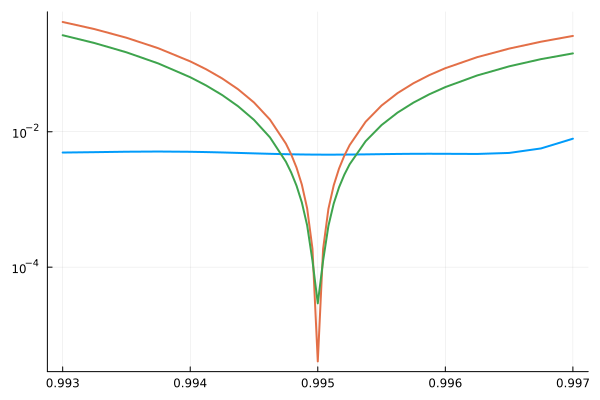

In [103]:
outputplot = plot(phis,[tmp_losses,tmp3_losses,tmp1_losses],yaxis=:log,linewidth=2,legend=nothing)

In [99]:
# savefig(outputplot,"BeautifulRobustness.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\BeautifulRobustness.pdf"

In [102]:
tmp1_losses./ones(11)

11-element Vector{Float64}:
 0.06382200265278937
 0.03991690415735
 0.021853458537448245
 0.00942874507165381
 0.002298652389022937
 2.9160349961532273e-5
 0.002149829165312145
 0.008195945371800739
 0.01773196293944468
 0.030350659263203628
 0.04564560806505197

┌ Warning: Skipped marker arg o.
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1203


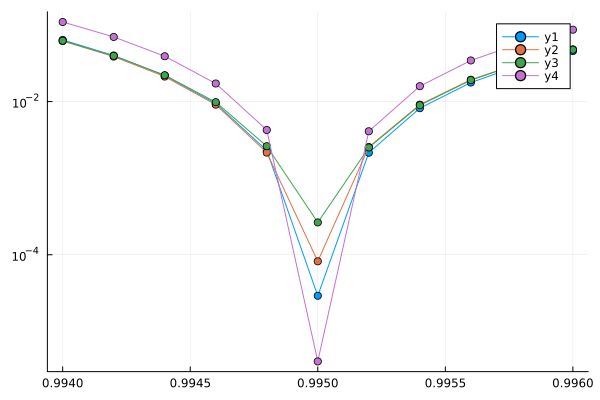

In [94]:
plot(LinRange(0.994,0.996,11),[tmp1_losses,tmp2_losses,tmp4_losses,tmp3_losses],yaxis=:log,marker="o")


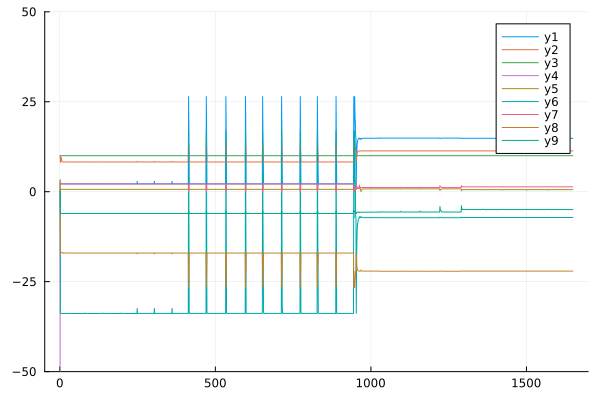

In [146]:
plot(transpose(cat(params...,dims=2)),ylim=(-50,50))


In [200]:
tmp = copy(p_new)
tmp[2] = limit_func(tmp[2],0,15)
tmp[1] = limit_func(tmp[1],0,15 - tmp[2])
tmp

9-element Vector{Float64}:
   1.5263572757019344
  11.472147443938331
  10.0
  -5.188952541845109
   0.6864151876375428
  -7.173438454226289
   0.7024191172650794
 -22.130712303163204
  -8.819182640524026

In [149]:
p_new

9-element Vector{Float64}:
   14.84292607534555
   11.341751839758764
   10.0
 -649.7661732132904
    0.5828557110984577
   -7.161153490188593
    1.3640811715268795
  -22.06506034791423
   -4.957612200539009